In [1]:
mutable struct Value
    label::String
    data::Float64
    _prev::Set{Value}
    _op::String
end

In [2]:
import Base.:+, Base.:*

val(label::String, x::Float64) = Value(label, x, Set(), "")

function +(a::Value, b::Value)
    return Value(
        "$(a.label) + $(b.label)",
        a.data + b.data,
        Set([a, b]),
        "+"
    )
end

function *(a::Value, b::Value)
    return Value(
        "$(a.label) * $(b.label)",
        a.data * b.data,
        Set([a, b]),
        "*"
    )
end

* (generic function with 319 methods)

In [10]:
a = val("a", 2.0)
b = val("b", -3.0)
c = val("c", 10.0)
d = a*b + c

Value("a * b + c", 4.0, Set(Value[Value("a * b", -6.0, Set(Value[Value("a", 2.0, Set{Value}(), ""), Value("b", -3.0, Set{Value}(), "")]), "*"), Value("c", 10.0, Set{Value}(), "")]), "+")

trace (generic function with 1 method)

In [136]:
using GraphViz

function trace(root::Value)
    nodes, edges = Set(), Set()

    function build(v::Value)
        if v ∉ nodes
            push!(nodes, v)
            for child in v._prev
                push!(edges, (child, v))
                build(child)
            end
        end
    end
    build(root)

    return nodes, edges
end

function dot_str(v::Value)::String
    nodes, edges = trace(v)
    lines = String[]

    for node in nodes
        uid = string(hash(node))
        push!(lines, """"$(uid)" [label="data = $(node.data)"; shape="record"]""")

        if node._op != ""
            push!(lines, """ "$(uid * node._op)" [label="$(node._op)"]""")
            push!(lines, """ "$(uid * node._op)" -> "$(uid)" """)
        end
    end
    for (a, b) in edges
        push!(lines, """ "$(string(hash(a)))" -> "$(string(hash(b)) * b._op)" """)
    end
    attrs = [
        "graph [rankdir=LR; ratio=0.5]"
    ]
    return "digraph G {\n\t" * join(attrs, "\n\t") * "\n" * join(lines, "\n\t") * "\n}"
end

function visualize(v::Value)
    g = GraphViz.Graph(dot_str(v))
    GraphViz.layout!(g, engine="dot")
    return g
end


visualize (generic function with 1 method)

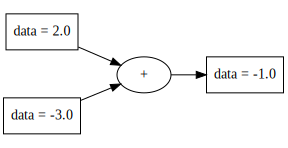

In [137]:
f = a + b
visualize(f)